<a href="https://colab.research.google.com/github/CWX-student/AI-ethics-coursework-1/blob/main/AI_ethics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 KB 4.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 22.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 3: Model Selection Strategy

#### 1) Suggest a model selection strategy (criterion) that accounts for both accuracy and fairness.

#### 2) Compare the standard model versus the fairness-aware model using the proposed criterion

#### 3) Accuracy and fairness for both models on the test set.

Standard Model


#### Training Dataset shape

(211848, 17)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['SEX']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([2.])]


#### Dataset feature names

['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']
1折划分: (169478,) (42370,)
2折划分: (169478,) (42370,)
3折划分: (169478,) (42370,)
4折划分: (169479,) (42369,)
5折划分: (169479,) (42369,)


IndexError: ignored

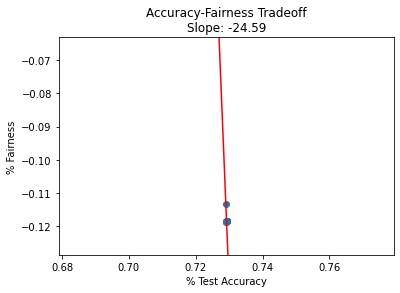

In [ ]:
'''
Coursework 1 - Caiwen Xu -  Fair classification.
'''
!pip install folktables
!pip install aif360
!pip install aif360[LawSchoolGPA]
!pip install aif360[Reductions]
!pip install aif360[Reductions]
!pip install aif360[Reductions]

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tqdm import tqdm

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.datasets import StandardDataset

import folktables
from folktables import ACSDataSource
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from aif360.algorithms.preprocessing.reweighing import Reweighing

np.random.seed(12345)

def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df


def load_ACSEmployment(state="CA", is_rm_f=False, rm_sen_f="RAC1P"):
    ACSEmployment = folktables.BasicProblem(
        features=[
            'AGEP', #age; for range of values of features please check Appendix B.4 of
            # Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
            'SCHL', #educational attainment
            'MAR', #marital status
            'RELP', #relationship
            'DIS', #disability recode
            'ESP', #employment status of parents
            'CIT', #citizenship status
            'MIG', #mobility status (lived here 1 year ago)
            'MIL', #military service
            'ANC', #ancestry recode
            'NATIVITY', #nativity
            'DEAR', #hearing difficulty
            'DEYE', #vision difficulty
            'DREM', #cognitive difficulty
            'SEX', #sex
            'RAC1P', #recoded detailed race code
            'GCL', #grandparents living with grandchildren
            ],
            target='ESR', #employment status recode
            target_transform=lambda x: x == 1,
            group='SEX',
            preprocess=employment_filter,
            postprocess=lambda x: np.nan_to_num(x, -1),
    )
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True) #data for California state
    features, label, group = ACSEmployment.df_to_numpy(acs_data)

    data = pd.DataFrame(features, columns = ACSEmployment.features)
    if is_rm_f is True and rm_sen_f is not None: 
        data = data.drop(rm_sen_f, axis=1) # drop a column
    data['label'] = label
    favorable_classes = [True]
    protected_attribute_names = [ACSEmployment.group]
    privileged_classes = np.array([[1]])
    data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
    protected_attribute_names = protected_attribute_names,
    privileged_classes = privileged_classes)
    privileged_groups = [{'SEX': 1}]
    unprivileged_groups = [{'SEX': 2}]
    return data_for_aif, privileged_groups, unprivileged_groups

def five_fold_split(dataset):
    import numpy as np  # 导入numpy包
    from sklearn.model_selection import KFold  # 从sklearn导入KFold包
    kf = KFold(n_splits=5)
    kfold_index = {}
    i = 0
    for train, val in kf.split(dataset.instance_names):
        i += 1
        print(f"{i}折划分: %s %s" % (train.shape, val.shape))
        index = {}
        index["train"], index["val"] = train, val
        kfold_index[str(i)] = index
    return kfold_index

def train_model(Standard_scaler, train_train, train_val, c, reweighting, unprivileged_groups, privileged_groups):
    train_train_x = Standard_scaler.fit_transform(train_train.features)
    train_train_y = train_train.labels.ravel()
    train_val_x = Standard_scaler.transform(train_val.features)
    train_val_y = train_val.labels.ravel()

    if reweighting is True:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1)
        model.fit(train_train_x, train_train_y, sample_weight=train_train.instance_weights)
    else:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1).fit(train_train_x, train_train_y)
    predictions = model.predict(train_val_x)
    val_pred = train_val.copy()
    val_pred.labels = predictions
    metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    # metrics for evaluation mentioned in the doc of this coursework
    acc = metric.accuracy()
    eod = metric.equal_opportunity_difference()
    # other metrics
    disparate_impact = metric.statistical_parity_difference()
    epo = metric.average_odds_difference()

    sr_spe = metric.specificity()
    spe = min(sr_spe, 1/sr_spe)

    sr_sen = metric.sensitivity()
    sen = min(sr_sen, 1/sr_sen)

    sr_pre = metric.precision()
    sr_rec = metric.recall()
    sr_f1_score = 2*(sr_pre*sr_rec)/(sr_pre+sr_rec)
    f1_score = min(sr_f1_score, 1/sr_f1_score)

    return model, acc, eod, disparate_impact, epo, spe, sen, f1_score, Standard_scaler

def plot_my(c_all, all_acc, all_epo, param, fair_m='statistical_parity_difference', best_param=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(c_all, all_acc)
    ax1.set_xlabel(param, fontsize=16, fontweight='bold')
    ax1.set_ylabel('Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(c_all, all_epo, color='r')
    ax2.set_ylabel(fair_m, color='r', fontsize=16, fontweight='bold')
    if best_param is not None:
        ax2.axvline(best_param, color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)     
    plt.show()

def load_dataset(state="NY", dataset_func=load_ACSEmployment,  **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = dataset_func(state=state,  **kwargs)
  if state=="NY":
    display(Markdown(f"#### {state} Dataset shape"))
    print(dataset_orig.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset_orig.favorable_label, dataset_orig.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset_orig.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset_orig.feature_names)
  return dataset_orig, privileged_groups, unprivileged_groups

def check_test(param_pair, test_x, dataset_orig_test, unprivileged_groups, privileged_groups, max_acc_pair, fair_pair1=None, fair_pair2=None, my_pair=None, istask3=False):
  if not istask3:
    test_c, test_acc, test_eod, test_disparate_impact, test_aod = [], [], [], [], []
    for pair in param_pair:
        model = pair[0]
        test_c.append(pair[1])
        predictions = model.predict(test_x)
        test_pred = dataset_orig_test.copy()
        test_pred.labels = predictions
        metric = ClassificationMetric(dataset_orig_test, test_pred, \
                        unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        test_acc.append(metric.accuracy())
        test_eod.append(metric.equal_opportunity_difference())

        if pair[1] == max_acc_pair[1]:
            display(Markdown("##### Test the model with the highest accuracy"))
            print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}")
        if pair[1] == fair_pair1[1]:    
            display(Markdown("##### Test the model with the best fairness Equal_opportunity_difference"))
            print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}") 
    display(Markdown("#### Figures:"))
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Equal_opportunity_difference', best_param=max_acc_pair[1])
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Equal_opportunity_difference', best_param=fair_pair1[1])
  elif istask3 and my_pair is not None:
    test_c, test_acc, test_eod, test_my = [], [], [], []
    for pair in param_pair:
        model = pair[0]
        test_c.append(pair[1])
        predictions = model.predict(test_x)
        test_pred = dataset_orig_test.copy()
        test_pred.labels = predictions
        metric = ClassificationMetric(dataset_orig_test, test_pred, \
                        unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        test_acc.append(metric.accuracy())
        test_eod.append(metric.equal_opportunity_difference())
        if pair[1] == my_pair[1]:
          my_acc, my_fair = metric.accuracy(), metric.equal_opportunity_difference()
          display(Markdown("##### Test the model with the highest my_strategy_metric"))
          print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}")
          
    display(Markdown("#### Figures:"))
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Fairness', best_param=my_pair[1])
    return my_acc, my_fair
  else:
    raise Exception("Sorry, Wrong input!")

def train_test(reweighting=True, state="CA", **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = load_dataset(state=state, dataset_func=load_ACSEmployment, **kwargs)
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
  display(Markdown("#### Training Dataset shape"))
  print(dataset_orig_train.features.shape)
  display(Markdown("#### Favorable and unfavorable labels"))
  print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
  display(Markdown("#### Protected attribute names"))
  print(dataset_orig_train.protected_attribute_names)
  display(Markdown("#### Privileged and unprivileged protected attribute values"))
  print(dataset_orig_train.privileged_protected_attributes, 
            dataset_orig_train.unprivileged_protected_attributes)
  display(Markdown("#### Dataset feature names"))
  print(dataset_orig_train.feature_names)

  kfold_index_dict = five_fold_split(dataset_orig_train)
    
  Standard_scaler = StandardScaler()
  all_acc, all_eod, all_disparate_impact, all_epo, all_spe, all_sen, all_f1_score = [], [], [], [], [], [], []
  param_pair = []
  c_all = np.arange(0.001, 1, 0.05)
  for c in c_all:
      accs, eods, disparate_impacts, epos, spes, sens, f1_scores = [], [], [], [], [], [], []
      for fold, index_arr in kfold_index_dict.items():
          train_train = dataset_orig_train.subset(list(kfold_index_dict[fold]['train']))
          train_val = dataset_orig_train.subset(list(kfold_index_dict[fold]['val']))
          'reweighting' 
          if reweighting is True: 
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups).fit(dataset_orig_train)
                train_train_transf = RW.transform(train_train)
          else:
                train_train_transf = train_train
          model, acc, eod, disparate_impact, epo, spe, sen, f1_score, Standard_scaler = \
          train_model(Standard_scaler, train_train_transf, train_val, c, reweighting=reweighting, \
                      unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) 
          accs.append(acc)
          eods.append(eod)
          disparate_impacts.append(disparate_impact)
          epos.append(epo)
          spes.append(spe)
          sens.append(sen)
          f1_scores.append(f1_score)
      param_pair.append((model, c, np.mean(accs), np.mean(eods), np.mean(disparate_impacts), np.mean(epos), np.mean(spes), np.mean(sens), np.mean(f1_scores)))
      all_acc.append(np.mean(accs))
      all_eod.append(np.mean(eods))
      all_disparate_impact.append(np.mean(disparate_impacts))
      all_epo.append(np.mean(epos))
      all_spe.append(np.mean(spes))
      all_sen.append(np.mean(sens))
      all_f1_score.append(np.mean(f1_scores))  
  max_acc_pair = max(param_pair, key=lambda x: x[2])
  fair_pair1 = min(param_pair, key=lambda x: abs(x[3]))
  display(Markdown("#### Results on the validation set"))
  print(f"The highest Acc model(C={max_acc_pair[1]}): Acc: {max_acc_pair[2]}, Equal_opportunity_difference: {max_acc_pair[3]}, Statistical_parity_difference: {max_acc_pair[4]}, and the Aaverage_odds_difference: {max_acc_pair[5]}")
  print(f"The min abs Equal_opportunity_difference model(C={fair_pair1[1]}): Acc: {fair_pair1[2]}, Equal_opportunity_difference: {max_acc_pair[3]}, Statistical_parity_difference: {fair_pair1[4]}, and the average_odds_difference: {fair_pair1[5]}")
  plot_my(c_all, all_acc, all_eod, "C", fair_m='Equal_opportunity_difference')

  display(Markdown("#### Results on the test set"))
  # CA test fold
  test_x = Standard_scaler.transform(dataset_orig_test.features)
  test_y = dataset_orig_test.labels.ravel()
  # NY test set
  NYdataset_orig, NYprivileged_groups, NYunprivileged_groups = load_dataset(state="NY", dataset_func=load_ACSEmployment, **kwargs)
  NYtest_x = Standard_scaler.transform(NYdataset_orig.features)
  # test
  display(Markdown("#### Results on the CA test set"))
  check_test(param_pair=param_pair, test_x=test_x, dataset_orig_test=dataset_orig_test, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, max_acc_pair=max_acc_pair, fair_pair1=fair_pair1, fair_pair2=None, my_pair=None, istask3=False)
  display(Markdown("#### Results on the NY test set"))
  check_test(param_pair, NYtest_x, NYdataset_orig, unprivileged_groups=NYunprivileged_groups, privileged_groups=NYprivileged_groups, max_acc_pair=max_acc_pair, fair_pair1=fair_pair1, fair_pair2=None, my_pair=None, istask3=False)

def task3_train_model(Standard_scaler, train_train, train_val, c, reweighting, unprivileged_groups, privileged_groups):
    train_train_x = Standard_scaler.fit_transform(train_train.features)
    train_train_y = train_train.labels.ravel()
    train_val_x = Standard_scaler.transform(train_val.features)
    train_val_y = train_val.labels.ravel()

    if reweighting is True:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1)
        model.fit(train_train_x, train_train_y, sample_weight=train_train.instance_weights)
    else:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1).fit(train_train_x, train_train_y)
    predictions = model.predict(train_val_x)
    val_pred = train_val.copy()
    val_pred.labels = predictions
    metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    acc = metric.accuracy()
    eod = metric.equal_opportunity_difference()
    # fair
    disparate_impact = metric.statistical_parity_difference()
    epo = metric.average_odds_difference()
    fair = 1-abs(eod)
    fair1 = 1-abs(disparate_impact) 
    fair2 = 1-abs(epo)
    # performance:
    spe = metric.specificity()
    sen = metric.sensitivity()

    sr_pre = metric.precision()
    sr_rec = metric.recall()
    f1_score = 2*(sr_pre*sr_rec)/(sr_pre+sr_rec)

    mix_all = (acc+spe+sen+f1_score+fair+fair1+fair2)/7
    mix_fair = (fair+fair1+fair2)/3
    mix_acc = (acc+spe+sen+f1_score)/4   
    my_strategy_metric0 = np.tanh(np.arctanh(acc)*np.arctanh(fair))
    my_strategy_metric1 = np.tanh(acc*0.7+fair*0.3)
    my_strategy_metric2 = fair
    my_strategy_metric3 = acc
    my_strategy_metric = [my_strategy_metric0, my_strategy_metric1, my_strategy_metric2, my_strategy_metric3]

    return model, acc, eod, disparate_impact, epo, my_strategy_metric, Standard_scaler

def trade_off(acc_fair, metric, thres):
  from sklearn.linear_model import LinearRegression
  import shapely.geometry as geometry
  from descartes import PolygonPatch

  acc = [x[0] for x in acc_fair]
  met = [x[1] for x in acc_fair]

  LR = LinearRegression(fit_intercept=True)
  LR.fit(np.array(acc).reshape(-1, 1), np.array(met).reshape(-1, 1))
  acc_ = np.arange(0, 1, 0.01)
  met_ = LR.predict(np.array(acc_).reshape(-1, 1))
  plt.scatter(acc, met)
  plt.plot(acc_, met_, c='r')
  plt.hlines(thres, 0, 1, linewidth=0.5, linestyles='dotted')
  plt.xlim(min(acc)-0.05, max(acc)+0.05)
  plt.ylim(min(met)-0.01, max(met)+0.05)
  plt.xlabel('% Test Accuracy')
  plt.ylabel('% {}'.format(metric))
  plt.title('Accuracy-{} Tradeoff'.format(metric) + '\n' + 'Slope: {}'.format(round(LR.coef_[0][0], 2)))
    
  point_collection = geometry.MultiPoint(list(acc_fair))
  patch = PolygonPatch(point_collection.convex_hull.buffer(0.005), fc='#999999',
                         ec='#000000', fill=True,
                         zorder=-1)
  ax = plt.gca()
  ax.add_patch(patch)
    
  plt.show()


def task3(reweighting=True, state="CA",  **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = load_dataset(state=state, dataset_func=load_ACSEmployment, **kwargs)
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
  display(Markdown("#### Training Dataset shape"))
  print(dataset_orig_train.features.shape)
  display(Markdown("#### Favorable and unfavorable labels"))
  print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
  display(Markdown("#### Protected attribute names"))
  print(dataset_orig_train.protected_attribute_names)
  display(Markdown("#### Privileged and unprivileged protected attribute values"))
  print(dataset_orig_train.privileged_protected_attributes, 
            dataset_orig_train.unprivileged_protected_attributes)
  display(Markdown("#### Dataset feature names"))
  print(dataset_orig_train.feature_names)

  kfold_index_dict = five_fold_split(dataset_orig_train)
    
  Standard_scaler = StandardScaler()
  all_acc, all_eod, all_disparate_impact, all_epo, all_my_strategy_metric0, \
  all_my_strategy_metric1, all_my_strategy_metric2, all_my_strategy_metric3 = [], [], [], [], [], [], [], []
  param_pair = []
  acc_fair = []
  c_all = np.arange(0.001, 1, 0.05)
  for c in c_all:
      accs, eods, disparate_impacts, epos, my_strategy_metrics0, \
      my_strategy_metrics1, my_strategy_metrics2, my_strategy_metrics3 = [], [], [], [], [], [], [], []
      for fold, index_arr in kfold_index_dict.items():
          train_train = dataset_orig_train.subset(list(kfold_index_dict[fold]['train']))
          train_val = dataset_orig_train.subset(list(kfold_index_dict[fold]['val']))
          'reweighting' 
          if reweighting is True: 
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups).fit(dataset_orig_train)
                train_train_transf = RW.transform(train_train)
          else:
                train_train_transf = train_train
          model, acc, eod, disparate_impact, epo, my_strategy_metric, Standard_scaler = \
          task3_train_model(Standard_scaler, train_train_transf, train_val, c, reweighting=reweighting, \
                      unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) 
          accs.append(acc)
          eods.append(eod)
          disparate_impacts.append(disparate_impact)
          epos.append(epo)
          my_strategy_metrics0.append(my_strategy_metric[0])
          my_strategy_metrics1.append(my_strategy_metric[1])
          my_strategy_metrics2.append(my_strategy_metric[2])
          my_strategy_metrics3.append(my_strategy_metric[3])

      

      param_pair.append((model, c, np.mean(accs), np.mean(eods), np.mean(disparate_impacts), np.mean(epos), \
                         np.mean(my_strategy_metrics0), np.mean(my_strategy_metrics1), \
                         np.mean(my_strategy_metrics2), np.mean(my_strategy_metrics3)))
      all_acc.append(np.mean(accs))
      all_eod.append(np.mean(eods))

      all_disparate_impact.append(np.mean(disparate_impacts))
      all_epo.append(np.mean(epos))
      all_my_strategy_metric0.append(np.mean(my_strategy_metrics0))
      all_my_strategy_metric1.append(np.mean(my_strategy_metrics1))
      all_my_strategy_metric2.append(np.mean(my_strategy_metrics2))
      all_my_strategy_metric3.append(np.mean(my_strategy_metrics3))

      acc_fair.append((np.mean(accs), np.mean(eods)))
  
  my_pair_best_m0 = max(param_pair, key=lambda x: abs(x[6]))
  my_pair_best_m1 = max(param_pair, key=lambda x: abs(x[7]))
  my_pair_best_m2 = max(param_pair, key=lambda x: abs(x[8]))
  my_pair_best_m3 = max(param_pair, key=lambda x: abs(x[9]))

  trade_off(acc_fair, "Fairness", 0.05)

  # my_strategy_metric0 = np.tanh(np.arctanh(acc)*np.arctanh(fair))
  # my_strategy_metric1 = np.tanh(np.arctanh(mix_acc)*np.arctanh(mix_fair))
  # my_strategy_metric2 = np.tanh(np.arctanh(mix_all))
  # my_strategy_metric3 = acc*0.5 + fair*0.5
  suggested_metrics = [all_my_strategy_metric0, all_my_strategy_metric1, all_my_strategy_metric2, all_my_strategy_metric3]
  my_pair_best_m = [my_pair_best_m0, my_pair_best_m1, my_pair_best_m2, my_pair_best_m3]
  CA_results, NY_results = [], []
  for num_suggested_metrics in range(len(my_pair_best_m)):
    display(Markdown(f"### Selection method {num_suggested_metrics}"))
    display(Markdown(f"#### Selection method{num_suggested_metrics} - Results on the validation set"))
    my_pair = my_pair_best_m[num_suggested_metrics]
    print(f"The model with the best my_strategy_metric(C={my_pair[1]})has achieved Acc: {my_pair[2]}, equal_opportunity_difference: {my_pair[3]}, Statistical_parity_difference: {my_pair[4]}, Average_odds_difference: {my_pair[5]}, My_strategy_metrics:{my_pair[6+num_suggested_metrics]}")
    plot_my(c_all, all_acc, suggested_metrics[num_suggested_metrics], "C", fair_m='my_strategy_metric')

    # test
    display(Markdown("#### Results on the test set"))
    test_x = Standard_scaler.transform(dataset_orig_test.features)
    test_y = dataset_orig_test.labels.ravel()
    # NY test set
    NYdataset_orig, NYprivileged_groups, NYunprivileged_groups = load_dataset(state="NY", dataset_func=load_ACSEmployment, **kwargs)
    NYtest_x = Standard_scaler.transform(NYdataset_orig.features)
    # test
    display(Markdown("#### Results on the CA test set"))
    CAmy_acc, CAmy_fair = check_test(param_pair=param_pair, test_x=test_x, dataset_orig_test=dataset_orig_test, \
              unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, \
              max_acc_pair=None, fair_pair1=None, fair_pair2=None, my_pair=my_pair, istask3=True)
    display(Markdown("#### Results on the NY test set"))
    NYmy_acc, NYmy_fair = check_test(param_pair=param_pair, test_x=NYtest_x, dataset_orig_test=NYdataset_orig, \
              unprivileged_groups=NYunprivileged_groups, privileged_groups=NYprivileged_groups, \
              max_acc_pair=None, fair_pair1=None, fair_pair2=None, my_pair=my_pair, istask3=True)
    CA_results.append((CAmy_acc, CAmy_fair, my_pair[1]))
    NY_results.append((NYmy_acc, NYmy_fair, my_pair[1]))

  return CA_results, NY_results

def plot_scatter(P):
  print(P)
  import matplotlib.pyplot as plt
  points = [[p[0], p[1]] for p in P]
  param = [p[2] for p in P]

  M_reduced= np.array(points)
  word2ind = {'M1': 0, 'M2': 1, 'M3': 2, 'M4': 3}
  words = ['M1', 'M2', 'M3', 'M4']
  fig = plt.figure()
  fig_sub1 = fig.add_subplot(111)
  for i in range(len(words)):
    fig_sub1.scatter(M_reduced[i,0],M_reduced[i, 1],color='r',marker='o')
    plt.annotate(words[i], xy = (M_reduced[word2ind[words[i]], 0], M_reduced[word2ind[words[i]], 1]), xytext = (M_reduced[word2ind[words[i]], 0]+0.001, M_reduced[word2ind[words[i]], 1]+0.001)) 
  plt.show()


if __name__ == "__main__":
    ############### Task 1   ###########################
    # display(Markdown("# Task 1: Standard Model"))
    # print("Using LOGSTIC REGRESSION")
    # train_test(reweighting=False)
    ############### Task 2   ###########################
    # display(Markdown("# Task 2: Fairness-aware Model"))
    # print("Using LOGSTIC REGRESSION and REWEIGHTING")
    # train_test(reweighting=True)

    ############### Task 3   ###########################
    display(Markdown("# Task 3: Model Selection Strategy"))
    display(Markdown("#### 1) Suggest a model selection strategy (criterion) that accounts for both accuracy and fairness."))
    display(Markdown("#### 2) Compare the standard model versus the fairness-aware model using the proposed criterion"))
    display(Markdown("#### 3) Accuracy and fairness for both models on the test set."))
    print("Standard Model")
    CA_results, NY_results = task3(reweighting=False)
    print("CA")
    plot_scatter(CA_results)
    print("NY")
    plot_scatter(NY_results)   
    print("Fairness-aware Model")
    CA_results, NY_results = task3(reweighting=True)
    print("CA")
    plot_scatter(CA_results)
    print("NY")
    plot_scatter(NY_results)
    ############### Other tasks ###########################
    # display(Markdown("# Task 4: test on data for New York (states=[”NY”]"))
    # display(Markdown("#### Implemented in previous tasks 1-3"))

    # display(Markdown("# Task 5: Exclude RAC1P from the features of X. and analyse how this change the performance of the models 1-6"))
    # display(Markdown("#### Model 1-2: Standard Model(task1)"))
    # train_test(reweighting=False, is_rm_f=True, rm_sen_f="RAC1P")
    # display(Markdown("#### Model 2-4: Fairness-aware Model(task2)"))
    # print("Using LOGSTIC REGRESSION and REWEIGHTING")
    # train_test(reweighting=True, is_rm_f=True, rm_sen_f="RAC1P")
    # display(Markdown("#### Model 4-6: task3"))
    # print("4-Standard Model")
    # task3(reweighting=False, is_rm_f=True, rm_sen_f="RAC1P")
    # print("6-Fairness-aware Model")
    # task3(reweighting=True, is_rm_f=True, rm_sen_f="RAC1P")





[(0.7391571361428795, -0.11942312736970118, 1), (0.7391571361428795, -0.11942312736970118, 1), (0.7391571361428795, -0.11942312736970118, 1), (0.7395331348895504, -0.12419677783161176, 1)]


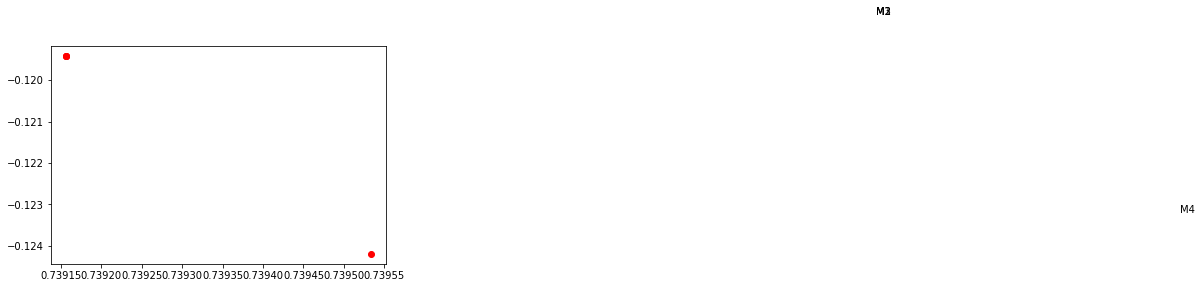

In [ ]:
def plot_scatter(P):
  print(P)
  import matplotlib.pyplot as plt
  points = [[p[0], p[1]] for p in P]
  param = [p[2] for p in P]

  M_reduced= np.array(points)
  word2ind = {'M1': 0, 'M2': 1, 'M3': 2, 'M4': 3}
  words = ['M1', 'M2', 'M3', 'M4']
  fig = plt.figure()
  fig_sub1 = fig.add_subplot(111)
  for i in range(len(words)):
    fig_sub1.scatter(M_reduced[i,0],M_reduced[i, 1],color='r',marker='o')
    plt.annotate(words[i], xy = (M_reduced[word2ind[words[i]], 0], M_reduced[word2ind[words[i]], 1]), xytext = (M_reduced[word2ind[words[i]], 0]+0.001, M_reduced[word2ind[words[i]], 1]+0.001)) 
  plt.show()
P = [(0.7391571361428795, -0.11942312736970118, 1), (0.7391571361428795, -0.11942312736970118, 1), (0.7391571361428795, -0.11942312736970118, 1), (0.7395331348895504, -0.12419677783161176, 1)]
plot_scatter(P)

divide by zero encountered in arctanh


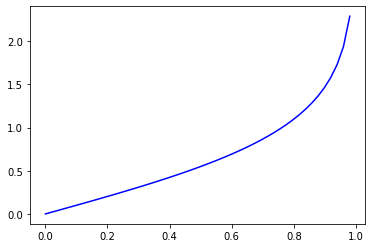

divide by zero encountered in arctanh


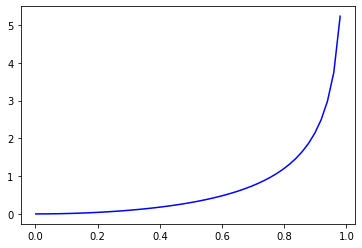

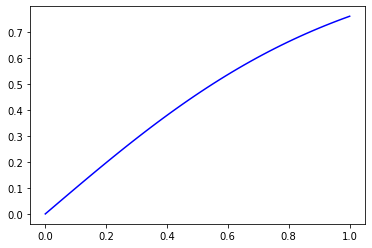

In [ ]:
import matplotlib.pyplot as plt
x = np.linspace(0.001, 1)
plt.plot(x, np.arctanh(x), c='b')
plt.axis('tight')
plt.show()

import matplotlib.pyplot as plt
x = np.linspace(0.001, 1)
plt.plot(x, np.arctanh(x)*np.arctanh(x), c='b')
plt.axis('tight')
plt.show()

import matplotlib.pyplot as plt
x = np.linspace(0.001, 1)
plt.plot(x, np.tanh(x), c='b')
plt.axis('tight')
plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.1/214.1 KB 4.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 10.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 KB 6.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Task 1: Standard Model

Using LOGSTIC REGRESSION


#### Training Dataset shape

(211848, 17)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['SEX']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([2.])]


#### Dataset feature names

['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']
1折划分: (169478,) (42370,)
2折划分: (169478,) (42370,)
3折划分: (169478,) (42370,)
4折划分: (169479,) (42369,)
5折划分: (169479,) (42369,)


#### Results on the validation set

The highest Acc model(C=0.401): Acc: 0.7292256722247502, Equal_opportunity_difference: -0.11851628740563154, Statistical_parity_difference: -0.14219827489406972, and the Aaverage_odds_difference: -0.10162427059997299
The min abs Equal_opportunity_difference model(C=0.001): Acc: 0.7290132571121093, Equal_opportunity_difference: -0.11317609028197573, Statistical_parity_difference: -0.1388297871567781, and the average_odds_difference: -0.09876319321924357


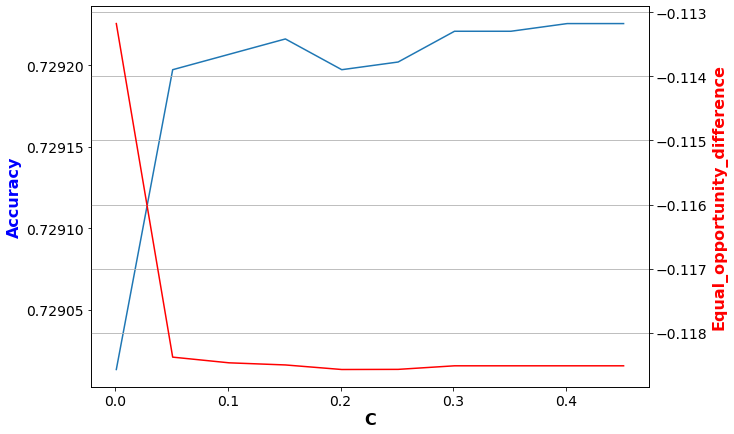

#### Results on the test set

#### NY Dataset shape

(159575, 17)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['SEX']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([2.])]


#### Dataset feature names

['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']


#### Results on the CA test set

##### Test the model with the best fairness Equal_opportunity_difference

Acc: 0.7243920169177901, Fair: -0.12190425530454152


##### Test the model with the highest accuracy

Acc: 0.7251850383293682, Fair: -0.12726014942707076


#### Figures:

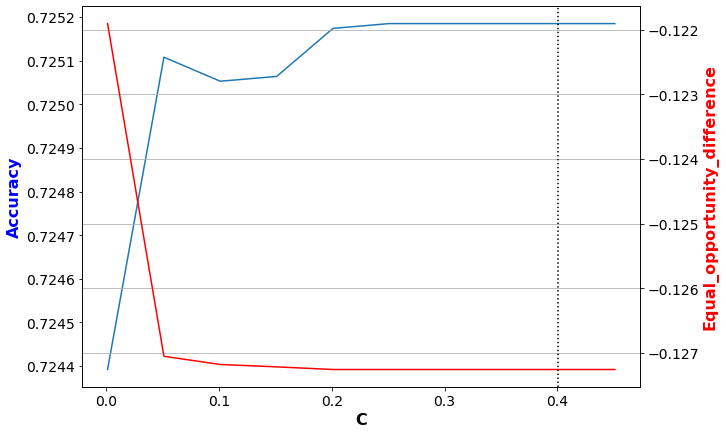

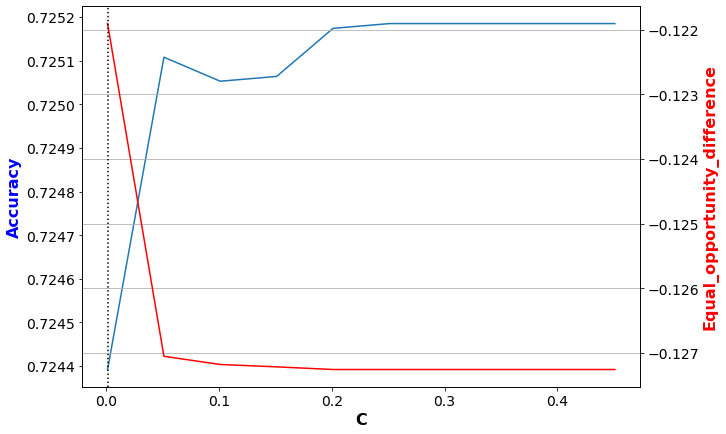

#### Results on the NY test set

##### Test the model with the best fairness Equal_opportunity_difference

Acc: 0.7391571361428795, Fair: -0.11942312736970118


##### Test the model with the highest accuracy

Acc: 0.7395331348895504, Fair: -0.12419677783161176


#### Figures:

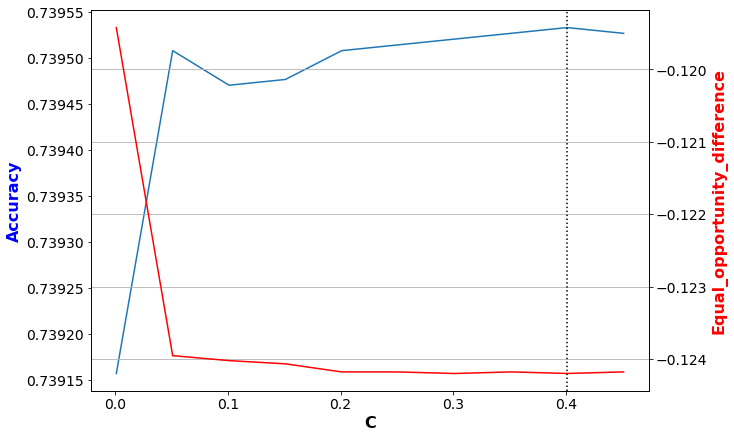

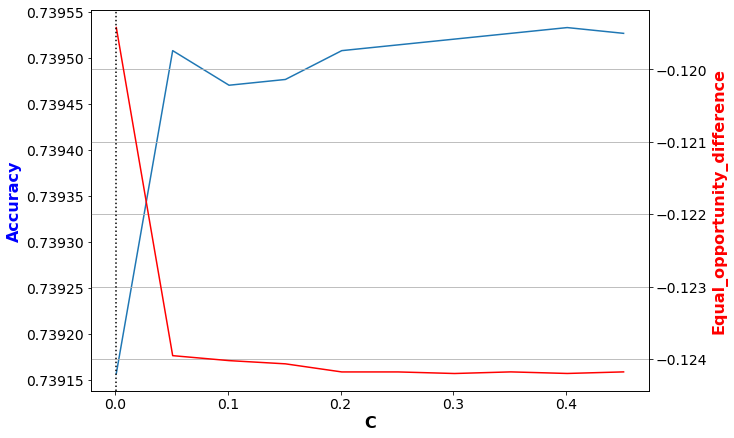

# Task 2: Fairness-aware Model

Using LOGSTIC REGRESSION and REWEIGHTING


#### Training Dataset shape

(211848, 17)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['SEX']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([2.])]


#### Dataset feature names

['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'GCL']
1折划分: (169478,) (42370,)
2折划分: (169478,) (42370,)
3折划分: (169478,) (42370,)
4折划分: (169479,) (42369,)
5折划分: (169479,) (42369,)


In [ ]:
'''
Coursework 1 - Caiwen Xu -  Fair classification.
'''
!pip install folktables
!pip install aif360
!pip install aif360[LawSchoolGPA]
!pip install aif360[Reductions]
!pip install aif360[Reductions]
!pip install aif360[Reductions]

from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from tqdm import tqdm

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.inprocessing import MetaFairClassifier
from aif360.datasets import StandardDataset

import folktables
from folktables import ACSDataSource
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from aif360.algorithms.preprocessing.reweighing import Reweighing

np.random.seed(12345)

def employment_filter(data):
    """
    Filters for the employment prediction task
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['AGEP'] < 90]
    df = df[df['PWGTP'] >= 1]
    return df


def load_ACSEmployment(state="CA", is_rm_f=False, rm_sen_f="RAC1P"):
    ACSEmployment = folktables.BasicProblem(
        features=[
            'AGEP', #age; for range of values of features please check Appendix B.4 of
            # Retiring Adult: New Datasets for Fair Machine Learning NeurIPS 2021 paper
            'SCHL', #educational attainment
            'MAR', #marital status
            'RELP', #relationship
            'DIS', #disability recode
            'ESP', #employment status of parents
            'CIT', #citizenship status
            'MIG', #mobility status (lived here 1 year ago)
            'MIL', #military service
            'ANC', #ancestry recode
            'NATIVITY', #nativity
            'DEAR', #hearing difficulty
            'DEYE', #vision difficulty
            'DREM', #cognitive difficulty
            'SEX', #sex
            'RAC1P', #recoded detailed race code
            'GCL', #grandparents living with grandchildren
            ],
            target='ESR', #employment status recode
            target_transform=lambda x: x == 1,
            group='SEX',
            preprocess=employment_filter,
            postprocess=lambda x: np.nan_to_num(x, -1),
    )
    data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
    acs_data = data_source.get_data(states=[state], download=True) #data for California state
    features, label, group = ACSEmployment.df_to_numpy(acs_data)

    data = pd.DataFrame(features, columns = ACSEmployment.features)
    if is_rm_f is True and rm_sen_f is not None: 
        data = data.drop(rm_sen_f, axis=1) # drop a column
    data['label'] = label
    favorable_classes = [True]
    protected_attribute_names = [ACSEmployment.group]
    privileged_classes = np.array([[1]])
    data_for_aif = StandardDataset(data, 'label', favorable_classes = favorable_classes,
    protected_attribute_names = protected_attribute_names,
    privileged_classes = privileged_classes)
    privileged_groups = [{'SEX': 1}]
    unprivileged_groups = [{'SEX': 2}]
    return data_for_aif, privileged_groups, unprivileged_groups

def five_fold_split(dataset):
    import numpy as np  # 导入numpy包
    from sklearn.model_selection import KFold  # 从sklearn导入KFold包
    kf = KFold(n_splits=5)
    kfold_index = {}
    i = 0
    for train, val in kf.split(dataset.instance_names):
        i += 1
        print(f"{i}折划分: %s %s" % (train.shape, val.shape))
        index = {}
        index["train"], index["val"] = train, val
        kfold_index[str(i)] = index
    return kfold_index

def train_model(Standard_scaler, train_train, train_val, c, reweighting, unprivileged_groups, privileged_groups):
    train_train_x = Standard_scaler.fit_transform(train_train.features)
    train_train_y = train_train.labels.ravel()
    train_val_x = Standard_scaler.transform(train_val.features)
    train_val_y = train_val.labels.ravel()

    if reweighting is True:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1)
        model.fit(train_train_x, train_train_y, sample_weight=train_train.instance_weights)
    else:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1).fit(train_train_x, train_train_y)
    predictions = model.predict(train_val_x)
    val_pred = train_val.copy()
    val_pred.labels = predictions
    metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    # metrics for evaluation mentioned in the doc of this coursework
    acc = metric.accuracy()
    eod = metric.equal_opportunity_difference()
    # other metrics
    disparate_impact = metric.statistical_parity_difference()
    epo = metric.average_odds_difference()

    sr_spe = metric.specificity()
    spe = min(sr_spe, 1/sr_spe)

    sr_sen = metric.sensitivity()
    sen = min(sr_sen, 1/sr_sen)

    sr_pre = metric.precision()
    sr_rec = metric.recall()
    sr_f1_score = 2*(sr_pre*sr_rec)/(sr_pre+sr_rec)
    f1_score = min(sr_f1_score, 1/sr_f1_score)

    return model, acc, eod, disparate_impact, epo, spe, sen, f1_score, Standard_scaler

def plot_my(c_all, all_acc, all_epo, param, fair_m='statistical_parity_difference', best_param=None):
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax1.plot(c_all, all_acc)
    ax1.set_xlabel(param, fontsize=16, fontweight='bold')
    ax1.set_ylabel('Accuracy', color='b', fontsize=16, fontweight='bold')
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)


    ax2 = ax1.twinx()
    ax2.plot(c_all, all_epo, color='r')
    ax2.set_ylabel(fair_m, color='r', fontsize=16, fontweight='bold')
    if best_param is not None:
        ax2.axvline(best_param, color='k', linestyle=':')
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.grid(True)     
    plt.show()

def load_dataset(state="NY", dataset_func=load_ACSEmployment,  **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = dataset_func(state=state,  **kwargs)
  if state=="NY":
    display(Markdown(f"#### {state} Dataset shape"))
    print(dataset_orig.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(dataset_orig.favorable_label, dataset_orig.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(dataset_orig.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(dataset_orig.privileged_protected_attributes, dataset_orig.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(dataset_orig.feature_names)
  return dataset_orig, privileged_groups, unprivileged_groups

def check_test(param_pair, test_x, dataset_orig_test, unprivileged_groups, privileged_groups, max_acc_pair, fair_pair1=None, fair_pair2=None, my_pair=None, istask3=False):
  if not istask3:
    test_c, test_acc, test_eod, test_disparate_impact, test_aod = [], [], [], [], []
    for pair in param_pair:
        model = pair[0]
        test_c.append(pair[1])
        predictions = model.predict(test_x)
        test_pred = dataset_orig_test.copy()
        test_pred.labels = predictions
        metric = ClassificationMetric(dataset_orig_test, test_pred, \
                        unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        test_acc.append(metric.accuracy())
        test_eod.append(metric.equal_opportunity_difference())

        if pair[1] == max_acc_pair[1]:
            display(Markdown("##### Test the model with the highest accuracy"))
            print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}")
        if pair[1] == fair_pair1[1]:    
            display(Markdown("##### Test the model with the best fairness Equal_opportunity_difference"))
            print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}") 
    display(Markdown("#### Figures:"))
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Equal_opportunity_difference', best_param=max_acc_pair[1])
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Equal_opportunity_difference', best_param=fair_pair1[1])
  elif istask3 and my_pair is not None:
    test_c, test_acc, test_eod, test_my = [], [], [], []
    for pair in param_pair:
        model = pair[0]
        test_c.append(pair[1])
        predictions = model.predict(test_x)
        test_pred = dataset_orig_test.copy()
        test_pred.labels = predictions
        metric = ClassificationMetric(dataset_orig_test, test_pred, \
                        unprivileged_groups=unprivileged_groups,privileged_groups=privileged_groups)
        test_acc.append(metric.accuracy())
        test_eod.append(metric.equal_opportunity_difference())
        if pair[1] == my_pair[1]:
          my_acc, my_fair = metric.accuracy(), metric.equal_opportunity_difference()
          display(Markdown("##### Test the model with the highest my_strategy_metric"))
          print(f"Acc: {metric.accuracy()}, Fair: {metric.equal_opportunity_difference()}")
          
    display(Markdown("#### Figures:"))
    plot_my(test_c, test_acc, test_eod, "C", fair_m='Fairness', best_param=my_pair[1])
    return my_acc, my_fair
  else:
    raise Exception("Sorry, Wrong input!")

def train_test(reweighting=True, state="CA", **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = load_dataset(state=state, dataset_func=load_ACSEmployment, **kwargs)
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
  display(Markdown("#### Training Dataset shape"))
  print(dataset_orig_train.features.shape)
  display(Markdown("#### Favorable and unfavorable labels"))
  print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
  display(Markdown("#### Protected attribute names"))
  print(dataset_orig_train.protected_attribute_names)
  display(Markdown("#### Privileged and unprivileged protected attribute values"))
  print(dataset_orig_train.privileged_protected_attributes, 
            dataset_orig_train.unprivileged_protected_attributes)
  display(Markdown("#### Dataset feature names"))
  print(dataset_orig_train.feature_names)

  kfold_index_dict = five_fold_split(dataset_orig_train)
    
  Standard_scaler = StandardScaler()
  all_acc, all_eod, all_disparate_impact, all_epo, all_spe, all_sen, all_f1_score = [], [], [], [], [], [], []
  param_pair = []
  c_all = np.arange(0.001, 0.5, 0.05)
  for c in c_all:
      accs, eods, disparate_impacts, epos, spes, sens, f1_scores = [], [], [], [], [], [], []
      for fold, index_arr in kfold_index_dict.items():
          train_train = dataset_orig_train.subset(list(kfold_index_dict[fold]['train']))
          train_val = dataset_orig_train.subset(list(kfold_index_dict[fold]['val']))
          'reweighting' 
          if reweighting is True: 
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups).fit(dataset_orig_train)
                train_train_transf = RW.transform(train_train)
          else:
                train_train_transf = train_train
          model, acc, eod, disparate_impact, epo, spe, sen, f1_score, Standard_scaler = \
          train_model(Standard_scaler, train_train_transf, train_val, c, reweighting=reweighting, \
                      unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) 
          accs.append(acc)
          eods.append(eod)
          disparate_impacts.append(disparate_impact)
          epos.append(epo)
          spes.append(spe)
          sens.append(sen)
          f1_scores.append(f1_score)
      param_pair.append((model, c, np.mean(accs), np.mean(eods), np.mean(disparate_impacts), np.mean(epos), np.mean(spes), np.mean(sens), np.mean(f1_scores)))
      all_acc.append(np.mean(accs))
      all_eod.append(np.mean(eods))
      all_disparate_impact.append(np.mean(disparate_impacts))
      all_epo.append(np.mean(epos))
      all_spe.append(np.mean(spes))
      all_sen.append(np.mean(sens))
      all_f1_score.append(np.mean(f1_scores))  
  max_acc_pair = max(param_pair, key=lambda x: x[2])
  fair_pair1 = min(param_pair, key=lambda x: abs(x[3]))
  display(Markdown("#### Results on the validation set"))
  print(f"The highest Acc model(C={max_acc_pair[1]}): Acc: {max_acc_pair[2]}, Equal_opportunity_difference: {max_acc_pair[3]}, Statistical_parity_difference: {max_acc_pair[4]}, and the Aaverage_odds_difference: {max_acc_pair[5]}")
  print(f"The min abs Equal_opportunity_difference model(C={fair_pair1[1]}): Acc: {fair_pair1[2]}, Equal_opportunity_difference: {fair_pair1[3]}, Statistical_parity_difference: {fair_pair1[4]}, and the average_odds_difference: {fair_pair1[5]}")
  plot_my(c_all, all_acc, all_eod, "C", fair_m='Equal_opportunity_difference')

  display(Markdown("#### Results on the test set"))
  # CA test fold
  test_x = Standard_scaler.transform(dataset_orig_test.features)
  test_y = dataset_orig_test.labels.ravel()
  # NY test set
  NYdataset_orig, NYprivileged_groups, NYunprivileged_groups = load_dataset(state="NY", dataset_func=load_ACSEmployment, **kwargs)
  NYtest_x = Standard_scaler.transform(NYdataset_orig.features)
  # test
  display(Markdown("#### Results on the CA test set"))
  check_test(param_pair=param_pair, test_x=test_x, dataset_orig_test=dataset_orig_test, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, max_acc_pair=max_acc_pair, fair_pair1=fair_pair1, fair_pair2=None, my_pair=None, istask3=False)
  display(Markdown("#### Results on the NY test set"))
  check_test(param_pair, NYtest_x, NYdataset_orig, unprivileged_groups=NYunprivileged_groups, privileged_groups=NYprivileged_groups, max_acc_pair=max_acc_pair, fair_pair1=fair_pair1, fair_pair2=None, my_pair=None, istask3=False)

def task3_train_model(Standard_scaler, train_train, train_val, c, reweighting, unprivileged_groups, privileged_groups):
    train_train_x = Standard_scaler.fit_transform(train_train.features)
    train_train_y = train_train.labels.ravel()
    train_val_x = Standard_scaler.transform(train_val.features)
    train_val_y = train_val.labels.ravel()

    if reweighting is True:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1)
        model.fit(train_train_x, train_train_y, sample_weight=train_train.instance_weights)
    else:
        model = LogisticRegression(C=c, penalty="l2", solver='liblinear', random_state=1).fit(train_train_x, train_train_y)
    predictions = model.predict(train_val_x)
    val_pred = train_val.copy()
    val_pred.labels = predictions
    metric = ClassificationMetric(train_val, val_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
    acc = metric.accuracy()
    eod = metric.equal_opportunity_difference()
    # fair
    disparate_impact = metric.statistical_parity_difference()
    epo = metric.average_odds_difference()
    fair = 1-abs(eod)
    fair1 = 1-abs(disparate_impact) 
    fair2 = 1-abs(epo)
    # performance:
    spe = metric.specificity()
    sen = metric.sensitivity()

    sr_pre = metric.precision()
    sr_rec = metric.recall()
    f1_score = 2*(sr_pre*sr_rec)/(sr_pre+sr_rec)

    mix_all = (spe+sen+f1_score+fair+fair1+fair2)/6
    mix_fair = (fair+fair1+fair2)/3
    mix_acc = (spe+sen+f1_score)/3   
    my_strategy_metric0 = np.tanh(np.arctanh(acc)*np.arctanh(fair))
    my_strategy_metric1 = np.tanh(np.arctanh(mix_acc)*np.arctanh(mix_fair))
    my_strategy_metric2 = np.tanh(np.arctanh(acc)*np.arctanh(fair)*np.arctanh(fair1)*np.arctanh(fair2)*np.arctanh(spe)*np.arctanh(sen)*np.arctanh(f1_score))
    # my_strategy_metric2 = max(0.123-abs(eod), 0)/(0.123-abs(eod))*acc
    my_strategy_metric3 = mix_all
    my_strategy_metric = [my_strategy_metric0, my_strategy_metric1, my_strategy_metric2, my_strategy_metric3]

    return model, acc, eod, disparate_impact, epo, my_strategy_metric, Standard_scaler

def trade_off(acc_fair, metric, thres):
  from sklearn.linear_model import LinearRegression
  import shapely.geometry as geometry
  from shapely.geometry import Polygon
  from descartes import PolygonPatch

  acc = [x[0] for x in acc_fair]
  met = [x[1] for x in acc_fair]

  LR = LinearRegression(fit_intercept=True)
  LR.fit(np.array(acc).reshape(-1, 1), np.array(met).reshape(-1, 1))
  acc_ = np.arange(0.5, 1, 0.001)
  met_ = LR.predict(np.array(acc_).reshape(-1, 1))
  plt.scatter(acc, met)
  plt.plot(acc_, met_, c='r')
  plt.hlines(thres, 0, 1, linewidth=0.5, linestyles='dotted')
  plt.xlim(min(acc)-0.0002, max(acc)+0.0002)
  plt.ylim(min(met)-0.0002, max(met)+0.0002)
  plt.xlabel('Test Accuracy')
  plt.ylabel('{}'.format(metric))
  plt.title('Accuracy-{} Tradeoff'.format(metric) + '\n' + 'Slope: {}'.format(round(LR.coef_[0][0], 2)))  
  plt.show()


def task3(reweighting=True, state="CA",  **kwargs):
  dataset_orig, privileged_groups, unprivileged_groups = load_dataset(state=state, dataset_func=load_ACSEmployment, **kwargs)
  dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)
  display(Markdown("#### Training Dataset shape"))
  print(dataset_orig_train.features.shape)
  display(Markdown("#### Favorable and unfavorable labels"))
  print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
  display(Markdown("#### Protected attribute names"))
  print(dataset_orig_train.protected_attribute_names)
  display(Markdown("#### Privileged and unprivileged protected attribute values"))
  print(dataset_orig_train.privileged_protected_attributes, 
            dataset_orig_train.unprivileged_protected_attributes)
  display(Markdown("#### Dataset feature names"))
  print(dataset_orig_train.feature_names)

  kfold_index_dict = five_fold_split(dataset_orig_train)
    
  Standard_scaler = StandardScaler()
  all_acc, all_eod, all_disparate_impact, all_epo, all_my_strategy_metric0, \
  all_my_strategy_metric1, all_my_strategy_metric2, all_my_strategy_metric3 = [], [], [], [], [], [], [], []
  param_pair = []
  acc_fair = []
  my_fair1, my_fair2, my_fair3, my_fair4 = [], [], [], []
  c_all = np.arange(0.001, 0.5, 0.05)
  for c in c_all:
      accs, eods, disparate_impacts, epos, my_strategy_metrics0, \
      my_strategy_metrics1, my_strategy_metrics2, my_strategy_metrics3 = [], [], [], [], [], [], [], []
      for fold, index_arr in kfold_index_dict.items():
          train_train = dataset_orig_train.subset(list(kfold_index_dict[fold]['train']))
          train_val = dataset_orig_train.subset(list(kfold_index_dict[fold]['val']))
          'reweighting' 
          if reweighting is True: 
                RW = Reweighing(unprivileged_groups=unprivileged_groups,
                                privileged_groups=privileged_groups).fit(dataset_orig_train)
                train_train_transf = RW.transform(train_train)
          else:
                train_train_transf = train_train
          model, acc, eod, disparate_impact, epo, my_strategy_metric, Standard_scaler = \
          task3_train_model(Standard_scaler, train_train_transf, train_val, c, reweighting=reweighting, \
                      unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups) 
          accs.append(acc)
          eods.append(eod)
          disparate_impacts.append(disparate_impact)
          epos.append(epo)
          my_strategy_metrics0.append(my_strategy_metric[0])
          my_strategy_metrics1.append(my_strategy_metric[1])
          my_strategy_metrics2.append(my_strategy_metric[2])
          my_strategy_metrics3.append(my_strategy_metric[3])

      

      param_pair.append((model, c, np.mean(accs), np.mean(eods), np.mean(disparate_impacts), np.mean(epos), \
                         np.mean(my_strategy_metrics0), np.mean(my_strategy_metrics1), \
                         np.mean(my_strategy_metrics2), np.mean(my_strategy_metrics3)))
      all_acc.append(np.mean(accs))
      all_eod.append(np.mean(eods))

      all_disparate_impact.append(np.mean(disparate_impacts))
      all_epo.append(np.mean(epos))
      all_my_strategy_metric0.append(np.mean(my_strategy_metrics0))
      all_my_strategy_metric1.append(np.mean(my_strategy_metrics1))
      all_my_strategy_metric2.append(np.mean(my_strategy_metrics2))
      all_my_strategy_metric3.append(np.mean(my_strategy_metrics3))

      acc_fair.append((np.mean(accs), abs(np.mean(eods))))
      my_fair1.append((np.mean(accs), -np.mean(my_strategy_metrics0)))
      my_fair2.append((np.mean(accs), -np.mean(my_strategy_metrics1)))
      my_fair3.append((np.mean(accs), -np.mean(my_strategy_metrics2)))
      my_fair4.append((np.mean(accs), -np.mean(my_strategy_metrics3)))
  
  my_pair_best_m0 = max(param_pair, key=lambda x: abs(x[6]))
  my_pair_best_m1 = max(param_pair, key=lambda x: abs(x[7]))
  my_pair_best_m2 = max(param_pair, key=lambda x: abs(x[8]))
  my_pair_best_m3 = max(param_pair, key=lambda x: abs(x[9]))

  trade_off(acc_fair, "-Fairness", 0.1135)
  trade_off(my_fair1, "-Fairness", 0.05)
  trade_off(my_fair2, "-Fairness", 0.05)
  trade_off(my_fair3, "-Fairness", 0.05)
  trade_off(my_fair4, "-Fairness", 0.05)

  suggested_metrics = [all_my_strategy_metric0, all_my_strategy_metric1, all_my_strategy_metric2, all_my_strategy_metric3]
  my_pair_best_m = [my_pair_best_m0, my_pair_best_m1, my_pair_best_m2, my_pair_best_m3]
  CA_results, NY_results = [], []
  for num_suggested_metrics in range(len(my_pair_best_m)):
    display(Markdown(f"### Selection method {num_suggested_metrics}"))
    display(Markdown(f"#### Selection method{num_suggested_metrics} - Results on the validation set"))
    my_pair = my_pair_best_m[num_suggested_metrics]
    print(f"The model with the best my_strategy_metric(C={my_pair[1]})has achieved Acc: {my_pair[2]}, equal_opportunity_difference: {my_pair[3]}, Statistical_parity_difference: {my_pair[4]}, Average_odds_difference: {my_pair[5]}, My_strategy_metrics:{my_pair[6+num_suggested_metrics]}")
    plot_my(c_all, all_acc, suggested_metrics[num_suggested_metrics], "C", fair_m='my_strategy_metric')

    # test
    display(Markdown("#### Results on the test set"))
    test_x = Standard_scaler.transform(dataset_orig_test.features)
    test_y = dataset_orig_test.labels.ravel()
    # NY test set
    NYdataset_orig, NYprivileged_groups, NYunprivileged_groups = load_dataset(state="NY", dataset_func=load_ACSEmployment, **kwargs)
    NYtest_x = Standard_scaler.transform(NYdataset_orig.features)
    # test
    display(Markdown("#### Results on the CA test set"))
    CAmy_acc, CAmy_fair = check_test(param_pair=param_pair, test_x=test_x, dataset_orig_test=dataset_orig_test, \
              unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, \
              max_acc_pair=None, fair_pair1=None, fair_pair2=None, my_pair=my_pair, istask3=True)
    display(Markdown("#### Results on the NY test set"))
    NYmy_acc, NYmy_fair = check_test(param_pair=param_pair, test_x=NYtest_x, dataset_orig_test=NYdataset_orig, \
              unprivileged_groups=NYunprivileged_groups, privileged_groups=NYprivileged_groups, \
              max_acc_pair=None, fair_pair1=None, fair_pair2=None, my_pair=my_pair, istask3=True)
    CA_results.append((CAmy_acc, CAmy_fair, my_pair[1]))
    NY_results.append((NYmy_acc, NYmy_fair, my_pair[1]))

  return CA_results, NY_results

def plot_scatter(P):
  print(P)
  import matplotlib.pyplot as plt
  points = [[p[0], p[1]] for p in P]
  param = [p[2] for p in P]

  M_reduced= np.array(points)
  word2ind = {'M1': 0, 'M2': 1, 'M3': 2, 'M4': 3}
  words = ['M1', 'M2', 'M3', 'M4']
  fig = plt.figure()
  fig_sub1 = fig.add_subplot(111)
  for i in range(len(words)):
    fig_sub1.scatter(M_reduced[i,0],M_reduced[i, 1],color='r',marker='o')
    plt.annotate(words[i], xy = (M_reduced[word2ind[words[i]], 0], M_reduced[word2ind[words[i]], 1]), xytext = (M_reduced[word2ind[words[i]], 0]+0.001, M_reduced[word2ind[words[i]], 1]+0.001)) 
  plt.show()


if __name__ == "__main__":
    ############### Task 1   ###########################
    display(Markdown("# Task 1: Standard Model"))
    print("Using LOGSTIC REGRESSION")
    train_test(reweighting=False)
    ############### Task 2   ###########################
    display(Markdown("# Task 2: Fairness-aware Model"))
    print("Using LOGSTIC REGRESSION and REWEIGHTING")
    train_test(reweighting=True)

    ############### Task 3   ###########################
    display(Markdown("# Task 3: Model Selection Strategy"))
    display(Markdown("#### 1) Suggest a model selection strategy (criterion) that accounts for both accuracy and fairness."))
    display(Markdown("#### 2) Compare the standard model versus the fairness-aware model using the proposed criterion"))
    display(Markdown("#### 3) Accuracy and fairness for both models on the test set."))
    print("Standard Model")
    CA_results, NY_results = task3(reweighting=False)  
    print("Fairness-aware Model")
    CA_results, NY_results = task3(reweighting=True)
    ############### Other tasks ###########################
    display(Markdown("# Task 4: test on data for New York (states=[”NY”]"))
    display(Markdown("#### Implemented in previous tasks 1-3"))

    display(Markdown("# Task 5: Exclude RAC1P from the features of X. and analyse how this change the performance of the models 1-6"))
    display(Markdown("#### Model 1-2: Standard Model(task1)"))
    train_test(reweighting=False, is_rm_f=True, rm_sen_f="RAC1P")
    display(Markdown("#### Model 2-4: Fairness-aware Model(task2)"))
    print("Using LOGSTIC REGRESSION and REWEIGHTING")
    train_test(reweighting=True, is_rm_f=True, rm_sen_f="RAC1P")
    display(Markdown("#### Model 4-6: task3"))
    print("4-Standard Model")
    task3(reweighting=False, is_rm_f=True, rm_sen_f="RAC1P")
    print("6-Fairness-aware Model")
    task3(reweighting=True, is_rm_f=True, rm_sen_f="RAC1P")

